# Question 2
This notebook approximates the limit cycle of a system

Import required libraries

In [1]:
import numpy as np
from scipy.integrate import solve_ivp  # Used to numerically solve the ODE
import matplotlib.pyplot as plt

In [2]:
from matplotlib.patches import Rectangle

Define the function (right hand side of the eqution).

In [3]:
x_ini = np.array([1., 1.])

def system(t=0, x=x_ini, mu=0):
    x_1, x_2 = x
    x_dot = np.empty_like(x)
    x_dot[0] = x_1 * (1 - x_1**2 - x_2**2) - x_2 + 2 * mu * x_1**2
    x_dot[1] = x_2 * (1 - x_1**2 - x_2**2) + x_1 + 2 * mu * x_1 * x_2
    return x_dot

We define the zeros of the function above (found analytically but you could also do this numerically).

In [4]:
def equilibria():
    # returned as a list of points (x_1, x_2)
    eq = [
        [0, 0] 
    ]
    return np.array(eq)

In [28]:
# funciton for plotting the phase space of a given system
def plot_phase_portrait(sys, eq, mu, x_bounds=[-2, 2], y_bounds=[-2, 2], ax=None):
    
    x = np.linspace(x_bounds[0], x_bounds[1], 100)
    y = np.linspace(y_bounds[0], y_bounds[1], 100)
    X, Y = np.meshgrid(x, y)
    U, V = sys(t=0, x=[X, Y], mu=mu)
    
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    ax.streamplot(X, Y, U, V, density=[0.7, 1])
    
    eq = equilibria()
    for e in eq:
        ax.plot(e[0], e[1], marker='o', c='red', ms=5)
        
    ax.set_xlim(x_bounds[0], x_bounds[1])
    ax.set_ylim(y_bounds[0], y_bounds[1])
    return ax
        

## Plot of the phase space (for different $\mu$)

<AxesSubplot:>

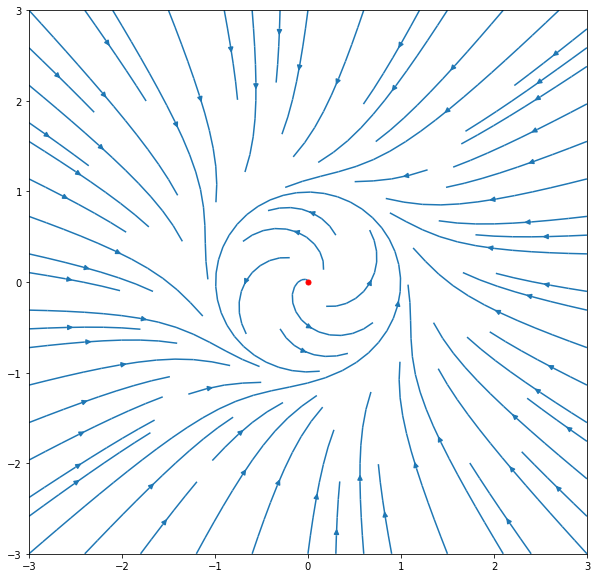

In [29]:
mu = 0
plot_phase_portrait(system, equilibria(), mu, x_bounds=[-3, 3], y_bounds=[-3, 3])

<AxesSubplot:>

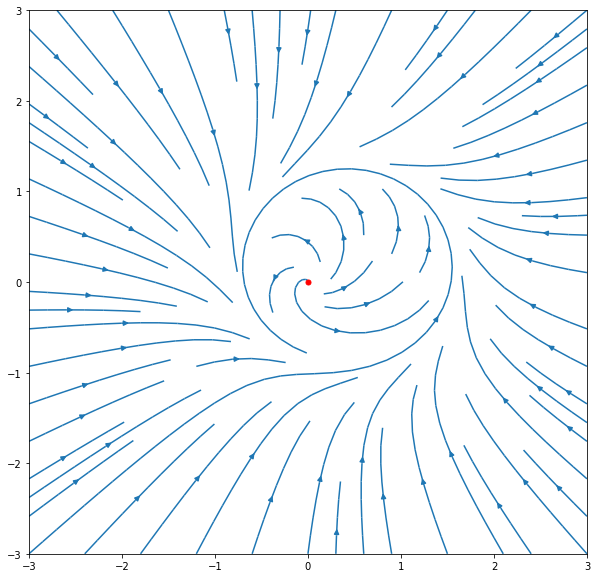

In [30]:
mu = 0.5
plot_phase_portrait(system, equilibria(), mu, x_bounds=[-3, 3], y_bounds=[-3, 3])

# Generating perturbation to many orders

In [31]:
import sympy as sy

In [32]:
r = sy.Symbol('r')
mu = sy.Symbol('mu')
theta = sy.Symbol('theta')

In [33]:
def make_symbolic_coeficients(order):
    # Generate coeficients
    coefs = list()
    r_expanded = 1
    for i in range(1, order+1):
        s = sy.Function('rho_'+str(i))(theta)
        coefs.append(s)
        r_expanded += s * mu ** i
    return r_expanded, coefs

In [34]:
def sym_solve_diff(order, eq_comb_1, dr_dtheta_coef, coefs):
    num_coefs = list()
    r_theta = 1
    
    for i in range(order-1):
        rhs = eq_comb_1[0].coeff(mu**(i+1))
        lhs = dr_dtheta_coef[0].coeff(mu**(i+1))
        diff_eq = sy.Equality(lhs, rhs)

        for j in range(i):
            diff_eq = diff_eq.subs(coefs[j], num_coefs[j].rhs)
        
        rho_func = sy.dsolve(diff_eq)
        rho_func = rho_func.subs(sy.Symbol('C1'), 0)
        num_coefs.append(rho_func)

        r_theta += rho_func.rhs * mu ** (i + 1)
    return r_theta

In [35]:
def make_approximation(order=2, return_str=False):
    # A function to make an approximation of the limit cycle
    
    # Required coeficients
    r_expanded, coefs = make_symbolic_coeficients(order)
    dr_dtheta = sy.diff(r_expanded, theta)
    dr_dtheta_coef = dr_dtheta.as_coeff_exponent(mu)
    
    # Symbolically make diff equations
    r_dot = r * (1 - r**2) + 2 * mu * r**2 * sy.cos(theta)
    eq_comb_1 = r_dot.subs(r, r_expanded).expand().as_coeff_exponent(mu)
    
    # Symbolically solve diff equations
    r_theta = sym_solve_diff(order, eq_comb_1, dr_dtheta_coef, coefs)
    
    # Make numpy function
    if return_str:
        return sy.lambdify((mu, theta), r_theta), r_theta
    else:
        return sy.lambdify((mu, theta), r_theta)

In [67]:
def plot_approx(f, mu_val, ax, colour, legend=None):
    theta_vals = np.linspace(0, np.pi * 2, 1000)
    r_vals = f(mu_val, np.linspace(0, np.pi * 2, 1000)) 
    x, y = r_vals * np.cos(theta_vals), r_vals * np.sin(theta_vals)
    ax.plot(x, y, c=colour, label=legend)

## Plot phase space 

Creating functions of different orders. This can be run up to order 7 within 6 minutes, beyond order 7 probably takes a painful amount of time.

In [73]:
%%time
order_functions = list()
approx_strings = list()
for i in range(7):
    print("Making approximation of order: " + str(i))
    temp = make_approximation(order=i, return_str=True)
    order_functions.append(temp[0])
    approx_strings.append(temp[1])

Making approximation of order: 0
Making approximation of order: 1
Making approximation of order: 2
Making approximation of order: 3
Making approximation of order: 4
Making approximation of order: 5
Making approximation of order: 6
CPU times: user 7min 32s, sys: 882 ms, total: 7min 33s
Wall time: 7min 33s


In [74]:
approx_strings[-1]

mu**5*(-117776*sin(theta)**5/1178125 + 254768*sin(theta)**4*cos(theta)/1178125 + 81382*sin(theta)/1178125 - 273579*sin(3*theta)/3063125 - 1773*sin(5*theta)/235625 - 78942*cos(theta)/1178125 + 64487*cos(3*theta)/15315625 + 2939*cos(5*theta)/235625) + mu**4*(-1317*sin(2*theta)/16250 - 17*sin(4*theta)/2600 + 34*cos(2*theta)**2/325 - 319*cos(2*theta)/16250 - 1057/13000) + mu**3*(-6*sin(theta)/125 + 12*sin(3*theta)/325 + 8*cos(theta)/125 + 34*cos(3*theta)/325) + mu**2*(9*sin(2*theta)/50 + 13*cos(2*theta)/50 + 1/5) + mu*(2*sin(theta)/5 + 4*cos(theta)/5) + 1

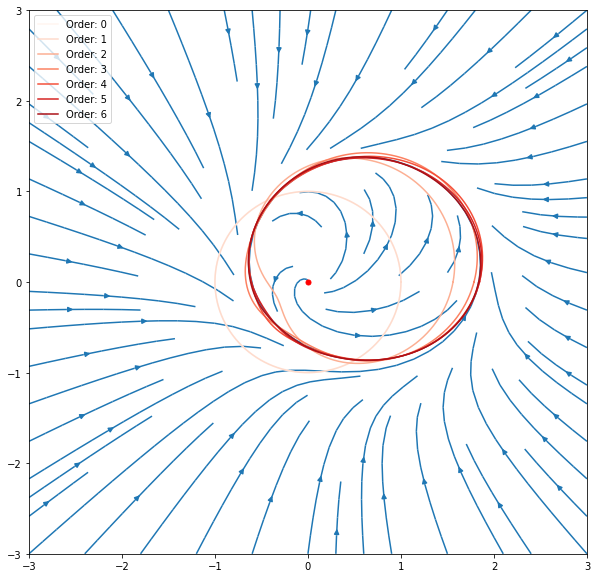

In [75]:
cmap = plt.get_cmap('Reds')

mu_val = 0.7

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

ax = plot_phase_portrait(system, equilibria(), mu_val, x_bounds=[-3, 3], y_bounds=[-3, 3], ax=ax)

for i, f in enumerate(order_functions):
    plot_approx(f, mu_val, ax, cmap(i / len(order_functions)), 'Order: ' + str(i))
ax.legend()

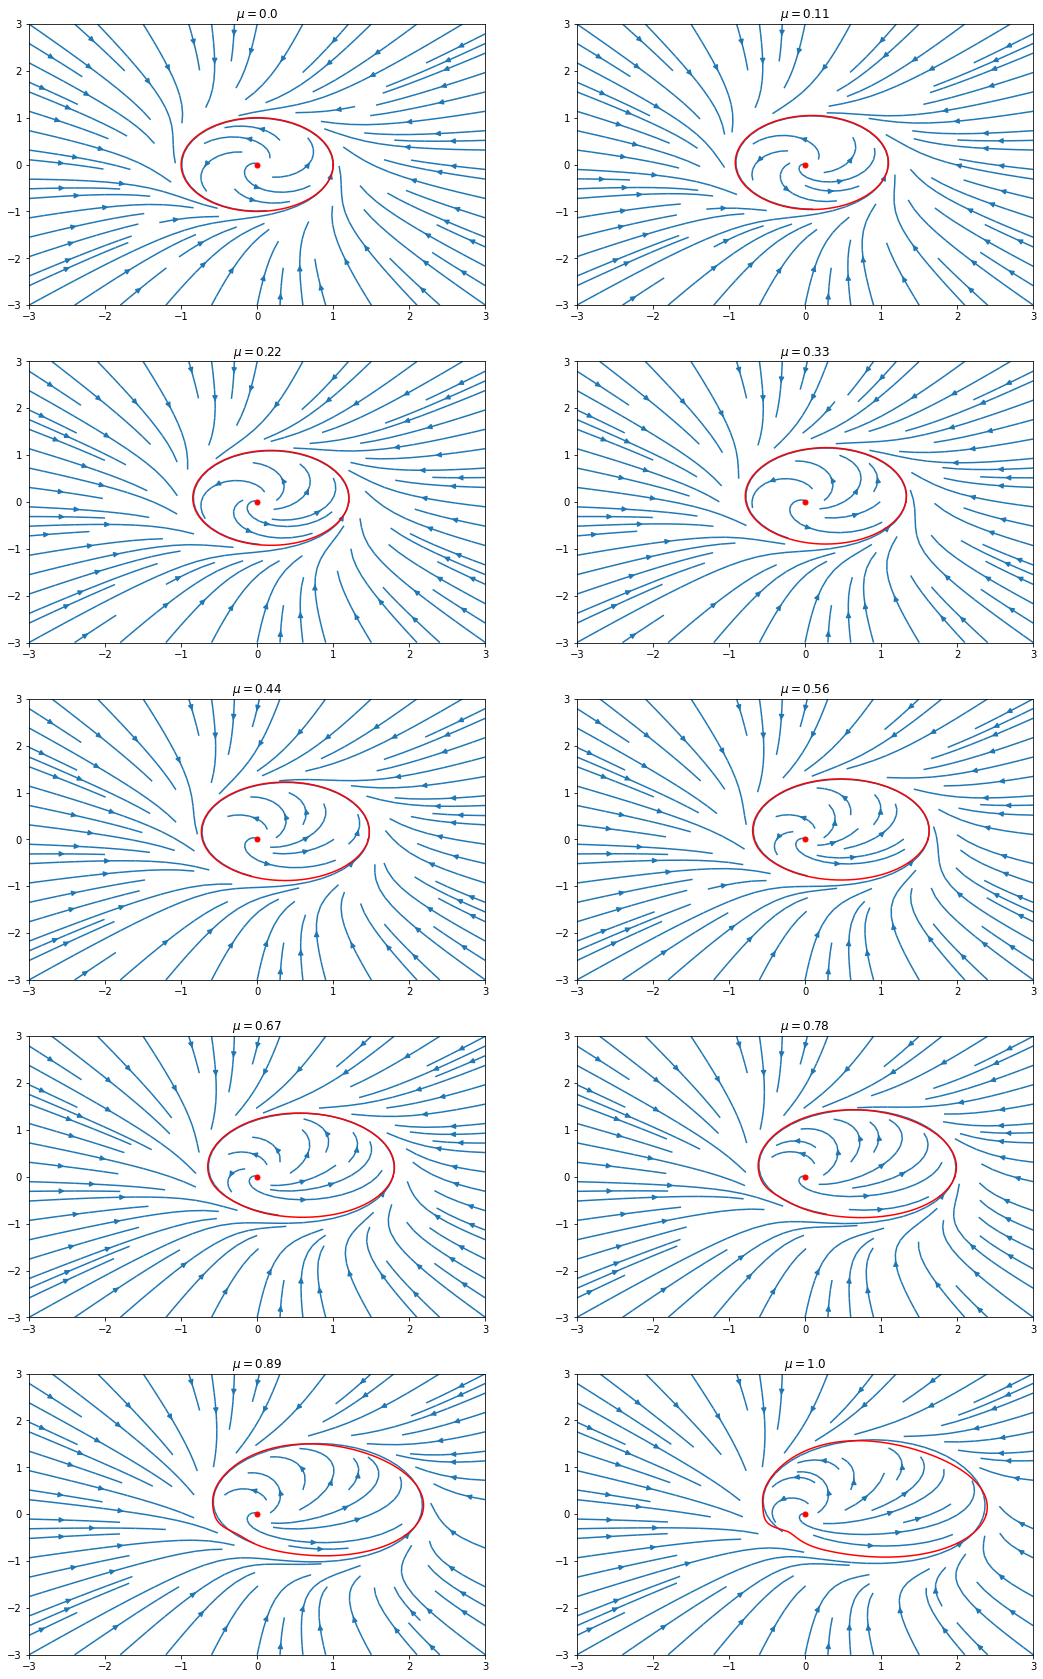

In [76]:
mu_vals = np.linspace(0, 1, 10)
fig, ax = plt.subplots(5, 2, figsize=(18, 30))

for i, m in enumerate(mu_vals):
    plt_i, plt_j = i // 2, i % 2
    plot_phase_portrait(system, equilibria(), m, x_bounds=[-3, 3], y_bounds=[-3, 3], ax=ax[plt_i, plt_j])
    ax[plt_i, plt_j].set_title(r"$\mu=$"+str(round(m, 2)))
    plot_approx(order_functions[-1], m, ax[plt_i, plt_j], 'r')